# Load libraries

In [2]:
%load_ext autoreload
%autoreload 2



# Basic libraries
import pandas as pd
import numpy as np
import sys



# Scipy
import scipy
from scipy import signal
from scipy.linalg import solve
from scipy import constants
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq

# Locate files
import os
from pathlib import Path
from glob import glob

# Plots
from matplotlib import pyplot as plt

#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data
from joblib import Parallel, delayed

""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs

from   SEA import SEA
import three_D_funcs as threeD
import download_data as download

sys.path.insert(1, os.path.join(os.getcwd(), 'functions/3d_anis_analysis_toolboox'))
import collect_wave_coeffs 
import data_analysis 



os.environ["CDF_LIB"] = "/Applications/cdf/cdf/lib"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download data

In [3]:

#User defined parameters 

cdf_lib_path            = '/Applications/cdf/cdf/lib'            # You will need to read cdf files. You have to specify the path

""" At this point you NEED credentials for function to work. This is because of the ephemeris data! Let me know if this doesnt work"""


credentials             =      { 'psp':{
                                           'fields': {'username': 'mvelli', 'password': 'flds@psp'},
                                           'sweap' : {'username': 'mvelli', 'password': '2019swe@pd@ta'}}}



settings                =  {
    
                    ###____How to handle data ____###
    
                            'Data_path'              : '/Volumes/Zesen-4TB/SPEDAS/',  # Path were pyspedas downloads data
                            'save_destination'       : '/Users/nokni/work/MHDTurbPy/examples/PSP/',
                            'use_local_data'         :  False,                        # Whether to donwload data(again) or use local data
                            'overwrite_files'        :  1,                            # In case you want to re-do analysis for existing files!
                            'save_all'               :  True,                         # If false it will only keep derived quants. Not timeseries
                            'addit_time_around'      :  2,                            # When loading at first it will return [start_time -addit_time_around [h], end_time + addit_time_around [h]]. The data are cut to the right dates later
                            'gap_time_threshold'     :  5 ,                           # Threshold for large gaps (units of seconds)
    
                       ###____Basics for the intervals ____###   
                            'sc'                     : 'PSP',                         # Choices ['PSP', SOLO, 'HELIOS_A', 'HELIOS_B', 'WIND']
                            'in_rtn'                 :  0,                          # RTN or spacecraft frame ( We will usually use RTN)
                            'multiple_intervals'     :  False,                         # If you only want to check one interval
    
                        ###____Only matters if 'Only_1_interval' ==False. It will essentially download adjacent intervals overlaping by 'Step'____###
                            'duration'               : '4H',                         # Duration of interval
                            'Step'                   : '210min',                     # Move starting point by step 
    
                            'start_date'             : '2018-11-02 00:00', 
                            'end_date'               : '2018-11-02 01:00',
                            'must_have_qtn'          :  0,                            # Dont consider interval if no qtn data. Only matters for PSP & SOLO
                            'Max_par_missing'        :  30,                           # Maximum fraction of missing particle data allowed
                            'particle_mode'          : '9th_perih_cut',               # Only for PSP: either: 'spc', 'span', '9th_perih_cut'
                            'max_PSP_dist'           : 0.4,                           # Maximum PSP distance to consider [au]
                            'part_resol'             : 300,                           # Max resol of plasma data                [ms]
                            'MAG_resol'              : 1,                             # Max resol og magnetic field data        [ms] [<230: Full resol mag data, >230 : 4_sa_per_sec dataset]
                            'upsample_low_freq_ts'   : False,                         # False: Whether to downsample mag data (after applying low-pass filter to make them match the cadence of velocity field data 

                    

                            'cut_in_small_windows'   : {
                                                        'flag'    : False, 
                                                        'njobs'   : 10,
                                                        'Step'    : '5s',          # Cuts each  larger interval in small windows. To avoid loading data again and again (Too slow)
                                                        'duration': '30s'},  
    
                            'Mag_SCAM_PSP': {'flag'         :  True,               # Set False to download fluxgate data
                                             'noise_flag'   :  False,
                                             'noise_removal': {
                                                                'window_size'         : 2**15,
                                                                'avg_length'          : 2,
                                                                'power_threshold'     : 3.0,
                                                                'freq_min'            : 1.0
                                                              }},
    
                            'E_field'    :  {'flag'                 : False,
                                             'cadence_seconds'      : 6,
                                             'fit_interval_minutes' : 4,
                                             'stride_minutes'       : 0.1,
                                             'min_correlation'      : 0.8
                                             },
    
                            'coherence_analysis' : {'flag'                  : False,
                                                    'method'                : {'min_var': ['B'], 
                                                                               'TN_only': ['B', 'E']},
                                                    'nv'                    : 8,
                                                    'alpha'                 : 3,
                                                    'per_thresh'            : 80,
                                                    'par_thresh'            : 10,
                                                    'coh_th'                : 0.7,
                                                    'num_efoldings'         : 3,
                                                    'njobs'                 : 10,
                                                    'est_mod'               : True,
                                                    'estimate_local_V'      : False,
                                                    
                                                    'do_coherence_analysis' : True,
                                                    'estimate_PSDs'         : True,
                                                    'estimate_coh_coeffs'   : True,
                                                    'estimate_comp'         : True,
                                                    'return_coeffs'         : False,
                                                    'est_sfuncs'            : False,
                                                    'max_qorder'            : 8
                            },
    
                            'PSDs'               : {'flag'                  : False},
                            'struc_funcs'        : {'flag'                  : False},
    
                            'npt_struc_funcs'    : {'flag'                  : False,
                                                    'five_points_sfunc'     : True,
                                                    'return_Bmod'           : True,
                                                    'dt_step'               : 0.25,
                                                    'est_sfuncs'            : False,
                                                    'max_qorder'            : 8
                            },

                     ###____Additional diagnostics ____###  
    
                            'estimate_derived_param' : True,
                            'rol_window'             : '60min',                          # When estimating fluctuations, size of window (centered around -w/2 -w/2
                            'apply_hampel'           : False,                         # Use hampelfilter to despike plasma data
                            'hampel_params'          : {'w':200, 'std':3},
                                                                                      # True : Upsample velocity field data
    
                            'estimate_psd_b'         : 1,                             # Estimate magentic field powes spectral density (keep false)
                            'estimate_psd_v'         : 1,                             # Estimate velocity field powes spectral density (keep false)
                            'est_PSD_components'     : 1,
                            'smooth_psd'             : False,
                            'Big_Gaps'               :{
                                                        'Mag_big_gaps' : 500,
                                                        'Par_big_gaps' : 5000,           # A file will be returned where gaps in the timeseries (larger than
                                                        'QTN_big_gaps' : 3000,          # those specified here [s]) are shown. This will enable the user to 
                                                                                       # omit the gappy data later
                                                        }                           
                            } 


# You can chnage those if more data are needed. Check /downloading_helpers/ PSP or SOLO to find default data to be downloaded
if settings['sc'] == "PSP":
    
    if settings['in_rtn']:
        vars_2_downnload = {
                            'mag'    : None, 
                            'span'   : None,
                            'span-a' : None,
                            'spc'    : None, 
                            'qtn'    : None,
                            'E_field': settings['E_field']['flag'],
                            'ephem'  : None}
    else:
        vars_2_downnload        = {  
                                    'mag'     : ['B_SC'],
                                    'span'    : ['DENS',  'VEL_SC', 'TEMP' , 'SUN_DIST'],
                                    'span-a'  : None,
                                    'spc'     : ['np_moment', 'wp_moment', 'vp_moment_SC','sc_pos_HCI'],
                                    'qtn'     : ['electron_density'],
            
                                    'E_field' : settings['E_field']['flag'],
            
                                    'ephem'   : None}      

elif settings['sc'] == "SOLO":
    vars_2_downnload = {
                        'mag'    : None,
                        'swa'    : None, 
                        'rpw'    : None, # Default is 'bia-density-10-seconds', but  'bia-density' is also available and probaly interesting
                        'ephem'  : None} 
else:
    
    print('Not ready yet!')
    



generated_interval_list = download.generate_intervals(settings['start_date'],
                                                      settings['end_date'], 
                                                      settings['multiple_intervals'],
                                                      data_path = settings['Data_path'],
                                                      settings  = settings)

# Save download files in specified dir
os.chdir(settings['Data_path'])

# Call function
Parallel(n_jobs=1)(delayed(download.download_files)(
                                                    jj, 
                                                    generated_interval_list, 
                                                    settings, 
                                                    vars_2_downnload, 
                                                    cdf_lib_path, 
                                                    credentials, 
                                                    Path(settings['save_destination'])) for jj in range( len(generated_interval_list)))


28-Jan-25 15:37:51: Generating only one interval based on the provided start and end times.
28-Jan-25 15:37:51: Start Time: 2018-11-02 00:00:00
28-Jan-25 15:37:51: End Time: 2018-11-02 01:00:00
28-Jan-25 15:37:51: Considering a single interval spanning: 2018-11-02 00:00:00 to 2018-11-02 01:00:00
28-Jan-25 15:37:51: Overwriting folder /Users/nokni/work/MHDTurbPy/examples/PSP/2018-11-02_00-00-00_2018-11-02_01-00-00_sc_0
28-Jan-25 15:37:51: Downloading remote index: https://sprg.ssl.berkeley.edu/data/spp/data/sci/fields/l3/sqtn_rfs_V1V2/2018/11/
28-Jan-25 15:37:51: File is current: psp_data/fields/l3/sqtn_rfs_V1V2/2018/11/psp_fld_l3_sqtn_rfs_V1V2_20181101_v1.0.cdf
28-Jan-25 15:37:51: File is current: psp_data/fields/l3/sqtn_rfs_V1V2/2018/11/psp_fld_l3_sqtn_rfs_V1V2_20181102_v1.0.cdf


Working on PSP data
QTN ['electron_density']
Using LEVEL=L3


28-Jan-25 15:37:51: Time clip was applied to: electron_density
28-Jan-25 15:37:51: File is current: psp_data/fields/l1/ephem_spp_rtn/2018/11/spp_fld_l1_ephem_spp_rtn_20181101_v01.cdf
28-Jan-25 15:37:52: File is current: psp_data/fields/l1/ephem_spp_rtn/2018/11/spp_fld_l1_ephem_spp_rtn_20181102_v01.cdf
28-Jan-25 15:37:52: Time clip was applied to: position
28-Jan-25 15:37:52: Time clip was applied to: velocity
28-Jan-25 15:37:52: Downloading remote index: https://sprg.ssl.berkeley.edu/data/spp/data/sci/fields/l3/merged_scam_wf/2018/11/


FLAG QTN QTN
2018-11-01 22:00:00
2018-11-02 03:00:00
Working on SCAM  mag data
Working on SC frame, SCAM DATA
Using LEVEL=L3


28-Jan-25 15:37:52: File is current: psp_data/fields/l3/merged_scam_wf/2018/11/psp_fld_l3_merged_scam_wf_2018110118_v02.cdf
28-Jan-25 15:37:52: File is current: psp_data/fields/l3/merged_scam_wf/2018/11/psp_fld_l3_merged_scam_wf_2018110200_v02.cdf
28-Jan-25 15:38:02: Time clip was applied to: psp_fld_l3_merged_scam_wf_SC
28-Jan-25 15:38:04: Downloading remote index: http://sweap.cfa.harvard.edu/data/sci/sweap/spi/L3/spi_sf00/2018/11/


Span Variables ['DENS', 'VEL_SC', 'TEMP', 'SUN_DIST']
Got here


28-Jan-25 15:38:05: File is current: psp_data/sweap/spi/L3/spi_sf00/2018/11/psp_swp_spi_sf00_L3_mom_20181101_v04.cdf
28-Jan-25 15:38:05: File is current: psp_data/sweap/spi/L3/spi_sf00/2018/11/psp_swp_spi_sf00_L3_mom_20181102_v04.cdf
28-Jan-25 15:38:05: Time clip was applied to: psp_spi_DENS
28-Jan-25 15:38:05: Time clip was applied to: psp_spi_VEL_SC
28-Jan-25 15:38:05: Time clip was applied to: psp_spi_TEMP
28-Jan-25 15:38:05: Time clip was applied to: psp_spi_SUN_DIST
28-Jan-25 15:38:05: Downloading remote index: http://sweap.cfa.harvard.edu/data/sci/sweap/spi/L3/spi_sf0a/2018/11/


28-Jan-25 15:38:05: File is current: psp_data/sweap/spi/L3/spi_sf0a/2018/11/psp_swp_spi_sf0a_L3_mom_20181101_v04.cdf
28-Jan-25 15:38:05: File is current: psp_data/sweap/spi/L3/spi_sf0a/2018/11/psp_swp_spi_sf0a_L3_mom_20181102_v04.cdf
28-Jan-25 15:38:05: Time clip was applied to: psp_spi_DENS
28-Jan-25 15:38:05: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)

28-Jan-25 15:38:05: Downloading remote index: http://sweap.cfa.harvard.edu/data/sci/sweap/spc/L3/2018/11/


Lenght fin: 69
Spc Variables ['np_moment', 'wp_moment', 'vp_moment_SC', 'sc_pos_HCI']
Using LEVEL=L3 (unpublished)


28-Jan-25 15:38:06: File is current: psp_data/sweap/spc/L3/2018/11/psp_swp_spc_l3i_20181101_v01.cdf
28-Jan-25 15:38:06: File is current: psp_data/sweap/spc/L3/2018/11/psp_swp_spc_l3i_20181102_v01.cdf
28-Jan-25 15:38:08: Time clip was applied to: psp_spc_np_moment
28-Jan-25 15:38:09: Time clip was applied to: psp_spc_wp_moment
28-Jan-25 15:38:09: Time clip was applied to: psp_spc_vp_moment_SC
28-Jan-25 15:38:09: Time clip was applied to: psp_spc_sc_pos_HCI


spc ['psp_spc_np_moment', 'psp_spc_wp_moment', 'psp_spc_vp_moment_SC', 'psp_spc_sc_pos_HCI']
No na
Index(['Bx', 'By', 'Bz'], dtype='object')
0 out of 1 finished


[None]

# Load data

In [4]:
#  User defined parameters
sc          = 'PSP'
which_int   = 0
load_path   =   f'/Users/nokni/work/MHDTurbPy/examples/{sc}'


# Locate the downloaded files
finnames  = func.load_files(load_path, 'final.pkl')
gennames  = func.load_files(load_path, 'general.pkl')
signames  = func.load_files(load_path, 'sig_c_sig_r.pkl')
maggaps   = func.load_files(load_path, 'mag_gaps.pkl')
qtngaps   = func.load_files(load_path, 'qtn_gaps.pkl')
pargaps   = func.load_files(load_path, 'par_gaps.pkl')


#Load the filed
fin      = pd.read_pickle(finnames[which_int])
gen      = pd.read_pickle(gennames[which_int])
sig      = pd.read_pickle(signames[which_int])
mag_gaps = pd.read_pickle(maggaps[which_int])
qtn_gaps = pd.read_pickle(qtngaps[which_int])
par_gaps = pd.read_pickle(pargaps[which_int])


finnames[which_int]

/Users/nokni/work/MHDTurbPy/examples/PSP/*/final.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/general.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/sig_c_sig_r.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/mag_gaps.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/qtn_gaps.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/par_gaps.pkl


'/Users/nokni/work/MHDTurbPy/examples/PSP/2018-11-02_00-00-00_2018-11-02_01-00-00_sc_0/final.pkl'

# Visualize data from downloaded interval

28-Jan-25 15:38:45: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
28-Jan-25 15:39:04: /Users/nokni/work/MHDTurbPy/functions/Figures.py:889: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



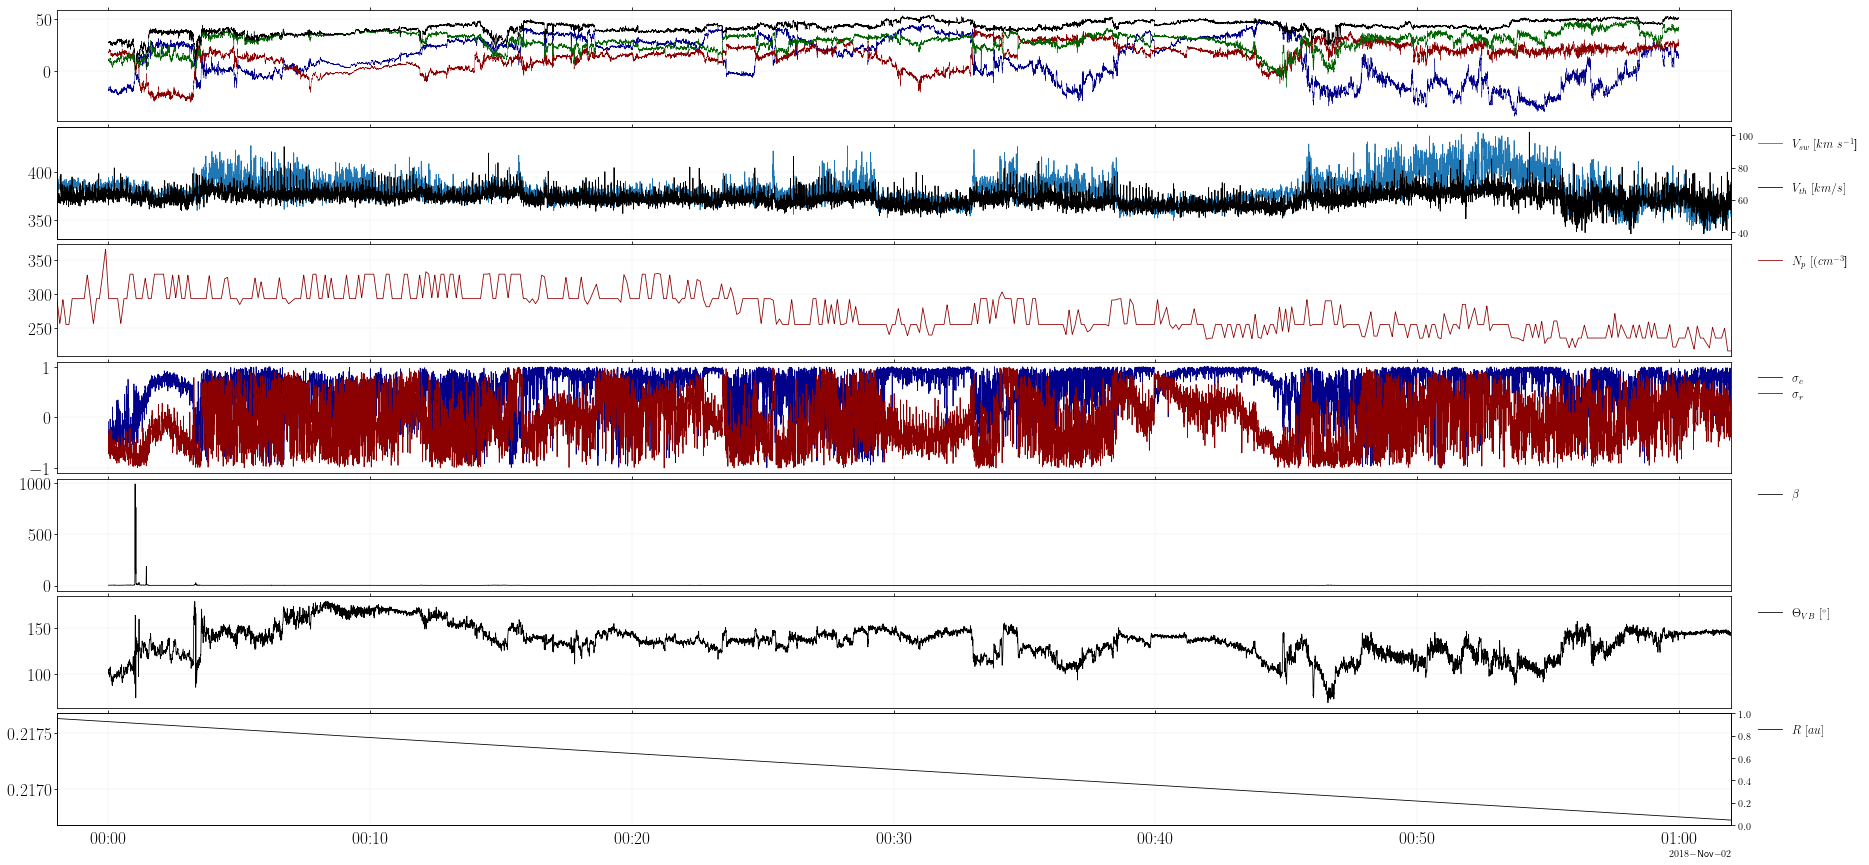

In [5]:
# user defined parameters
sc                = 'PSP'
label_size        = 21                                    # labels etc

n_subplots        = 7                                     # number os subplots
my_dir            = '/Users/nokni/work/MHDTurbPy/examples/' #
format_2_return   = "%Y_%m_%d"                            # Format to save figures


figs.visualize_downloaded_intervals(
                                  sc                         ,
                                  fin['Par']['V_resampled'],
                                  fin['Mag']['B_resampled'],
                                  sig     ,
                                  my_dir,
                                  format_2_return  = "%Y_%m_%d",  #
                                  size             = label_size,
                                  numb_subplots    = n_subplots
                                 )



# Estimate Power Spectral Density (PSD) of the magnetic field.
 - When using high resolution data, 'smoothing_function' is going to be slow!

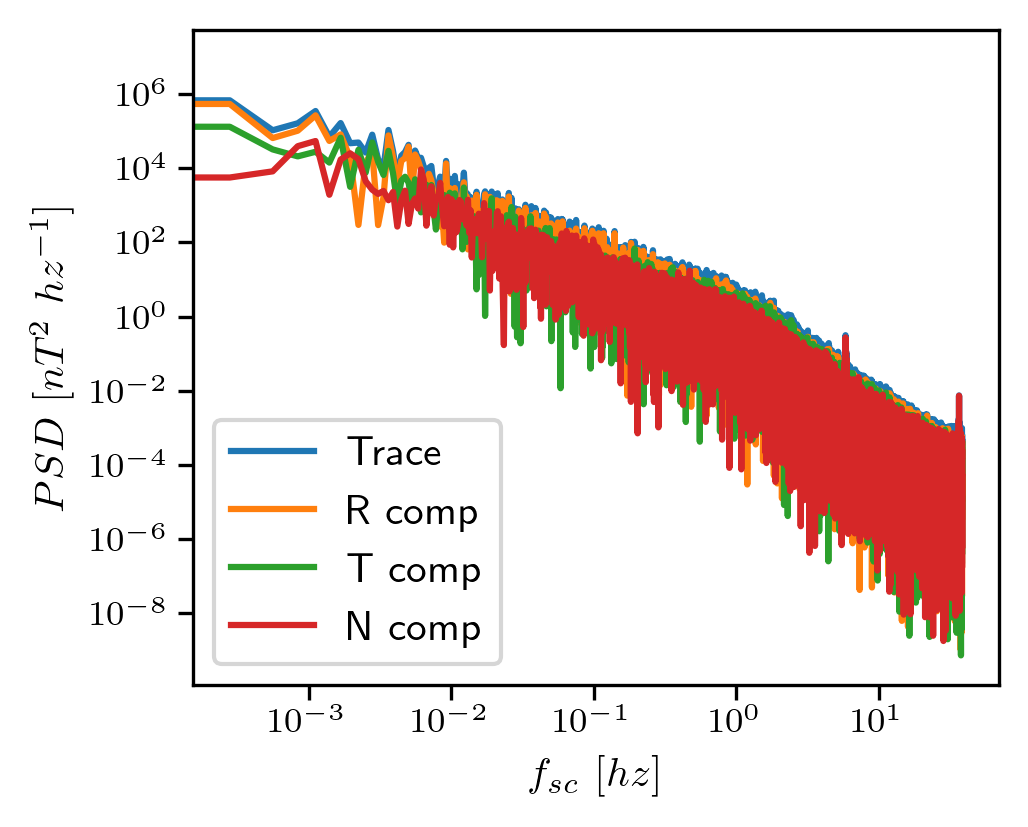

In [6]:
fig, ax =figs.initializeFigure(r'$PSD ~[nT^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig'], label ='Trace')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_R'], label ='R comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_T'], label ='T comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_N'], label ='N comp')

plt.legend()

# Smooth and fit the PSD

In [ ]:
# Define fit range
x0, xf = 8e-4, 1e-2


# Initialize figure
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


# Smooth the PSD using a window of 2
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])



# Estimate fit 
fit, s, e, x, y = func.find_fit(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'], x0, xf)


# Add legend
lab_name =r'$\propto f^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit[0][1],2), round(np.sqrt(fit[1][1][1]),2))


# Plot everything
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
plt.loglog(sm[0], sm[1], label ='smoothed')
plt.loglog(x[s:e],5*fit[2], 'k-.', lw=1.2, ls='-',label=lab_name) 



plt.legend(frameon=0)


28-Jan-25 15:40:33: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot normalized cross helicity and residual energy spectrum

In [ ]:
fig, ax =figs.initializeFigure(r'', r'$f_{sc} ~[hz]$')


zp = fin['Par']['dict_psd']['psd_zp']
zm = fin['Par']['dict_psd']['psd_zm']

va = fin['Par']['dict_psd']['psd_b']
v  = fin['Par']['dict_psd']['psd_v']

plt.yscale('linear')
plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm), label =r'$\sigma_c$')
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm))
plt.semilogx(sm[0], sm[1],c='k')

plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va), alpha=0.5,  label =r'$\sigma_r$')
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va))
plt.semilogx(sm[0], sm[1],c='k')

# Smooth the PSD using a window of 2

plt.axvline(fin['Par']['dict_psd']['f_zpm'][ind[0]])
plt.axhline(y=0)
plt.legend(frameon=0)

#  Estimate PVI Timeseries

In [ ]:
# User defined parameters
hours                  = 4                             # Averaging window in denominator (Hours)
hmany                  = [5, 100, 500]               # Estimate PVI timeseries using a lag of \ell =hmany*di
taus                   = None
B_df                   = fin['Mag']['B_resampled']
V_df                   = fin['Par']['V_resampled']

#
di                     = fin['Par']['di_mean']       # Mean value of ion inertial length for the interval
Vsw                    = fin['Par']['Vsw_mean']      # Mean value of Solar wind speed  for the interval

# Define figure labels
ylabel, xlabel         = r'$PVI$',  r"$Date$"
inset_f_size           = 7



# Run function
PVI_ts                 =turb.estimate_PVI(B_df,
                                           hmany, 
                                           taus,
                                           di,
                                           Vsw,
                                           hours,
                                           PVI_vec_or_mod='vec'
                                          )



# init Figure
fig, ax  = figs.initializeFigure(ylabel, xlabel, '1col')

for kk in range(len(hmany)):
    ax.plot(PVI_ts['PVI_'+str(hmany[kk])], ls='-', ms=0, lw=0.1, label =r'$PVI(\ell= {%d} d_{i})$'%(hmany[kk]))
    
    # # Estimate PDF of PVI
    # res =func.pdf(PVI_ts['PVI_'+str(hmany[kk])].dropna().values, nbins, loglog, density)
    # ax2.semilogy(res[0], res[1], ls='-', ms=0, lw=0.1,c ='C'+str(kk))
    # ax2.set_ylabel(r'$p(PVI)$')
    # ax2.set_ylabel(r'$PVI$')
    


ax.legend(loc=0, )
ax.set_ylim([0,None])


# Superposed epoch analysis
- For more information check (https://github.com/nsioulas/SEA)


In [ ]:
# user defined parameters
time_around        = '1000s'   # Time around identified events
which_one          =  'Vth'    # Parameter to be plotted on y axis
mean_or_median     =  0        # Estimate mean (1) or median (0) of events
resample_rate      =  '800ms'  # Cadence of joined timeseries
which_one_2_plot   = 0 


# you can actually aplly multiple conditions
condit_variables   = ['PVI_500']#, 'sigma_r']
conditions         = [['>=']]#, ['>=','<='] ]
threshold_values   = [[1]]#, [-0.15, 0.1]]


ylabel, xlabel     = r'$V_{th} ~[km/s]$',  r"$\delta \ell ~[d_i]$"


# Merge the two dfs
f_df = PVI_ts.resample(resample_rate ).mean().join(
     V_df.resample(resample_rate ).mean()
)


# run SEA function
results  = SEA(f_df,
              condit_variables,
              threshold_values,
              conditions,
              time_around,
              which_one,
              mean_or_median,
              resample_rate)


# Assign
keys =list(results.keys())
xvals, yvals, y_std, y_std_err_mean = results[keys[which_one_2_plot]]


# convert temporal lag to spatial and normalize with di
di_lag    = Vsw*xvals/di

# init Figure
fig, ax   = figs.initializeFigure(ylabel, xlabel, '1col')

ax.plot(di_lag, yvals, ls='-', ms=0, lw=0.1)
    